# Around the States in 78 Days: An Analysis of My Summer Roadtrip

## Introduction

I recently took a cross-country roadtrip to celebrate completing my master's degree, explore some personally untraveled parts of the United States, and enjoy being out in nature while hiking in the national parks. It occurred to me near the end of my trip that it would be fun to do some data analysis of my travels after I returned home, so I decided to make a small project out of it. My general aim was to do some exploratory data analysis (EDA) and generate visualizations based on the following categories of data:

- Driving mileage
- Fuel efficiency and gas prices
- Walking/hiking mileage
- Biometric data from my smartwatch
- Expenses for lodging, fuel, food, etc.
- Distribution of the previously mentioned data across time and geography

I wanted to answer the following questions:

- What are the basic descriptive statistics for each of the above mentioned categories of data?
- Are there any interesting insights that can be derived from combining or comparing data from one or more of these categories?
- What can I learn from this data that would improve my travel experience for future trips?


### Table of Contents

<ul>
<li><a href="#data_sourcing">Collecting the Data</a></li>
<li><a href="#preparation">Data Preparation</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

***

<a id='data_sourcing'></a>
## Collecting the Data

Since I didn't have the idea for this project until about a week before I finished my trip, data collection and organization was done entirely post hoc, starting with compiling my data as a daily time series in Google Sheets since it would be straight-forward to export as a CSV and convert to a Pandas DataFrame later as needed. The first step after creating a spreadsheet was figuring out how many miles I drove each day. This would have been easier if I had recorded the value of my car's odometer every day before starting to drive, but alas, I only had the values at the start and end of the entire trip. These numbers told me that **I drove a total of 14,093 miles** over the course of approximately 11 weeks. Not too shabby.

I turned to Google Maps for assistance at this point, estimating my route each day using custom maps in the My Maps feature. Since each custom map is limited to 10 route layers, I made a layer for each day of the trip and split them up into different maps for each 10-day period of the trip. Using a combination of my photos, journal entries and *\*impeccable geographical memory\**, I added an ordered list of waypoints to each daily layer for each of the major stops I made on the trip, and Google Maps automatically calculated the fastest route between the waypoints, which provided mileage values for each day. Some of the paths required modification since I chose to take the longer but more scenic route quite often. 

![example image of My Maps path](./images/my_maps_example.PNG)
<p style="text-align: center;"><em>Figure 1: Example My Maps paths for a 10-day period.</em></p><br>

Although it took a while to map out my daily routes, I realized after doing so that I also then had an easy way to get my final location at the end of each day, the place where I slept. I input this information into my spreadsheet as two seperate variables for latititude and longitude of my daily sleeping location. I also added a variable to my spreadsheet to keep track of what type of lodging I stayed in each night (car, tent, hotel, etc.), as well as a Boolean variable for whether I took a shower.

Next came biometric data, which I knew had been recorded by my Garmin watch during the trip. After [requesting all my personal data from Garmin](https://support.garmin.com/en-US/?faq=q22kMdCbU23NUT2Wmspz16), I found two relevant JSON files: one that contained daily activity and heart rate data, and another that contained detailed sleep metrics. From here I could extract the data that I wanted and save them to CSV files, from which I could easily copy my data into the spreadsheet.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import pytz
from timezonefinder import TimezoneFinder

In [2]:
# Load the activity data and select the relevant subset
activity_path = './roadtrip_data/UDSFile_2024-04-19_2024-07-28.json'
activity_df = pd.read_json(activity_path)
activity_df = activity_df[[
    'calendarDate',
    'totalSteps',
    'totalDistanceMeters',
    'floorsAscendedInMeters',
    'floorsDescendedInMeters',
    'minHeartRate',
    'maxHeartRate',
    'restingHeartRate',
    'bmrKilocalories',
    'activeKilocalories'
]]

# Export activity data to a CSV file
activity_df.to_csv('./roadtrip_data/activity_data.csv', index=False)

# Load the sleep data and select the relevant subset
sleep_path = './roadtrip_data/2024-04-19_2024-07-28_120037738_sleepData.json'
sleep_df = pd.read_json(sleep_path)
sleep_df = sleep_df[[
    'calendarDate',
    'deepSleepSeconds',
    'lightSleepSeconds',
    'remSleepSeconds',
    'awakeSleepSeconds',
    'unmeasurableSeconds',
    'restlessMomentCount',
    'sleepStartTimestampGMT',
    'sleepEndTimestampGMT'
]]

# Export sleep data to a CSV file
sleep_df.to_csv('./roadtrip_data/sleep_data.csv', index=False)

Finding my daily costs over the course of the trip proved to be the most time-consuming part of compiling my data since I had to look through my credit card statements and sort each expense into the appropriate category. I created a variable for daily amount spent on lodging, food, gas, gifts (e.g., paying for meals for friends who joined me along the way or making dinner for friends who let me crash at their place), and random other expenses.

I decided for the sake of simplicity not to attempt to estimate fuel efficiency at this point. I now had a single spreadsheet with the following variables:

| Variable Name           | Type       | Category  | Description                                                                 |
|-------------------------|------------|-----------|-----------------------------------------------------------------------------|
| `day`                     | int   | Logistics | Day of the trip                                                             |
| `date`                    | datetime     | Logistics | Date of the entry                                                           |
| `miles_driven`            | int    | Logistics | Total miles driven on the day                                               |
| `sleeping_lat`            | float      | Logistics | Latitude of the location where I slept                               |
| `sleeping_long`           | float      | Logistics | Longitude of the location where I slept                             |
| `showered`                | boolean    | Logistics | Indicates whether I took a shower on the day                                        |
| `lodging_type`            | str     | Logistics | Type of lodging used (e.g., home, car, friend)                              |
| `lodging_cost`            | float   | Cost      | Cost of lodging for the night                                               |
| `food_cost`               | float   | Cost      | Total cost of food for the day                                              |
| `gift_cost`               | float   | Cost      | Total cost of gifts purchased on the day                                    |
| `other_cost`              | float   | Cost      | Total cost of other expenses on the day                                     |
| `miles_walked`            | float      | Biometric | Total miles walked on the day                                               |
| `feet_gained`             | float      | Biometric | Total feet of elevation gained during the day                               |
| `feet_lost`               | float      | Biometric | Total feet of elevation lost during the day                                 |
| `min_hr`                  | int    | Biometric | Minimum heart rate recorded during the day                                  |
| `max_hr`                  | int    | Biometric | Maximum heart rate recorded during the day                                  |
| `resting_hr`              | int    | Biometric | Resting heart rate during the day                                                       |
| `resting_calories`        | int    | Biometric | Calories burned while at rest on the day                                               |
| `active_calories`         | int    | Biometric | Calories burned during physical activity on the day                                   |
| `deep_sleep_seconds`      | int    | Biometric | Total seconds spent in deep sleep                                           |
| `light_sleep_seconds`     | int    | Biometric | Total seconds spent in light sleep                                          |
| `rem_sleep_seconds`       | int    | Biometric | Total seconds spent in REM sleep                                            |
| `awake_sleep_seconds`     | int    | Biometric | Total seconds spent awake period                                      |
| `unmeasurable_seconds`    | int    | Biometric | Total seconds of unmeasurable sleep data period                                 |
| `restless_moment_count`   | int    | Biometric | Number of restless moments during sleep                                     |
| `sleep_start_timestamp`   | datetime  | Biometric | Timestamp indicating when sleep started                                     |
| `sleep_end_timestamp`     | datetime  | Biometric | Timestamp indicating when sleep ended                                       |


<a id='preparation'></a>
## Data Preparation

After adding the daily mileage values to my spreadsheet, the total mileage I got from summing them was a couple hundred miles less than 14,093. Although this seemed like a significant amount of unaccounted mileage at first glance, it was less than 2% of the total mileage. When I divided the unaccounted mileage up between all the days that had non-zero mileage, it was only about 3.5 miles per day. Considering that I didn't account for stops to get gas or snacks and probably took occasional detours to avoid traffic, it seemed reasonable to account for the difference by adding 3.5 miles to each driving day.

Additionally, the total distance walked and elevation gain/loss were reported by Garmin in meters, so I converted these columns to feet in the spreadsheet. At this point I had all the data in one place and in the units I wanted to work with, so it was time to read in the spreadsheet as a Pandas DataFrame and complete any additional data preparation.

### Converting CSV to DataFrame

In [3]:
df = pd.read_csv('./roadtrip_data/all_data.csv')
df.set_index('day', inplace=True)

# View first 5 rows
df.iloc[range(1,6)]

,date,miles_driven,sleeping_lat,sleeping_long,showered,lodging_type,lodging_cost,food_cost,gift_cost,other_cost,...,resting_calories,active_calories,deep_sleep_seconds,light_sleep_seconds,rem_sleep_seconds,awake_sleep_seconds,unmeasurable_seconds,restless_moment_count,sleep_start_timestamp,sleep_end_timestamp
day,,,,,,,,,,,,,,,,,,,,,
1,9-May,614,34.618133,-93.181233,False,car,$16.51,$4,$0,$0,...,1919,160,8880.0,7740.0,4500.0,120.0,0.0,30.0,5/9/2024 4:19,5/9/2024 10:13
2,10-May,566,30.240641,-97.720495,True,friend,$0,$20,$2.20,$35.08,...,1843,474,6960.0,13620.0,7980.0,2940.0,0.0,26.0,5/10/2024 2:04,5/10/2024 10:49
3,11-May,0,30.240641,-97.720495,True,friend,$0,$39,$36.31,$0,...,1843,894,8220.0,9060.0,5520.0,0.0,0.0,19.0,5/11/2024 4:29,5/11/2024 10:49
4,12-May,31,30.240641,-97.720495,True,friend,$0,$19,$0,$0,...,1843,112,7380.0,10800.0,8940.0,120.0,0.0,23.0,5/12/2024 4:21,5/12/2024 11:55
5,13-May,27,30.240641,-97.720495,True,friend,$0,$18,$0,$0,...,1843,455,7080.0,11580.0,9840.0,0.0,0.0,33.0,5/13/2024 3:22,5/13/2024 11:17


In [4]:
# Get an overview of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79 entries, 0 to 78
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   79 non-null     object 
 1   miles_driven           79 non-null     int64  
 2   sleeping_lat           79 non-null     float64
 3   sleeping_long          79 non-null     float64
 4   showered               79 non-null     bool   
 5   lodging_type           79 non-null     object 
 6   lodging_cost           79 non-null     object 
 7   food_cost              79 non-null     object 
 8   gift_cost              79 non-null     object 
 9   other_cost             79 non-null     object 
 10  miles_walked           79 non-null     float64
 11  feet_gained            79 non-null     float64
 12  feet_lost              79 non-null     float64
 13  min_hr                 79 non-null     int64  
 14  max_hr                 79 non-null     int64  
 15  resting_hr   

### Handling Duplicates

In [5]:
# Check for duplicates
df.duplicated().sum()

0

I didn't expect there to be any duplicate rows in the DataFrame, but it's always good to check.

### Handling Missing Values

I noticed in the info summary for the dataframe that there are at least a few null values present, so let's take a closer look at that:

In [6]:
# Only show columns that have at least one null value
null_columns = df.isnull().any()
df[df.columns[null_columns]].isnull().sum()

deep_sleep_seconds       7
light_sleep_seconds      7
rem_sleep_seconds        7
awake_sleep_seconds      7
unmeasurable_seconds     7
restless_moment_count    7
sleep_start_timestamp    7
sleep_end_timestamp      7
dtype: int64

These null values are from the seven days on the trip that I didn't wear my smartwatch while sleeping, most likely because I had to charge it. Let's see how the days where I'm missing sleep data are distributed:

In [7]:
# Get dates with null values
null_rows = df[df['deep_sleep_seconds'].isnull()]
null_rows[['date']]

,date
day,
17,25-May
25,2-Jun
49,26-Jun
56,3-Jul
71,18-Jul
72,19-Jul
73,20-Jul


In [8]:
# Display stats for columns with missing data
df[df.columns[null_columns]].describe()

,deep_sleep_seconds,light_sleep_seconds,rem_sleep_seconds,awake_sleep_seconds,unmeasurable_seconds,restless_moment_count
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,6796.666667,11702.500000,5795.000000,700.000000,364.166667,26.319444
std,1747.203802,3041.700669,1977.187503,1305.981904,688.930075,9.406061
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5820.000000,9345.000000,4470.000000,60.000000,0.000000,19.000000
50%,7020.000000,11610.000000,6030.000000,360.000000,0.000000,26.000000
75%,8100.000000,14040.000000,7080.000000,900.000000,180.000000,34.000000
max,9660.000000,17400.000000,9840.000000,9900.000000,2460.000000,46.000000


The missing days are fairly spread apart (except for the cluster of three days toward the end of the trip). Let's visualize what filling in the null values using mean imputation would look like for the `deep_sleep_seconds` variable:

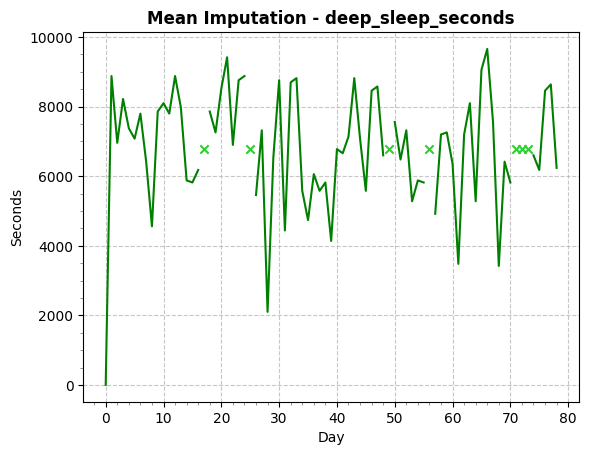

In [9]:
# Plot the non-null deep sleep values
df['deep_sleep_seconds'].plot(color='green')

# Plot the mean-imputed missing values
null_rows.loc[:, 'deep_sleep_seconds'] = df['deep_sleep_seconds'].mean()
plt.scatter(
    x=null_rows.index,
    y=null_rows['deep_sleep_seconds'],
    marker='x',
    color='limegreen'
);

plt.grid(True, linestyle='--', alpha=0.7)
plt.minorticks_on()
plt.tick_params(axis='both', which='minor', color='gray')
plt.title('Mean Imputation - deep_sleep_seconds', fontweight='bold')
plt.xlabel('Day')
plt.ylabel('Seconds');

Nothing looks awry graphically, so we'll move forward with using the mean to fill in the variables for types of sleep and restless moments.

In [10]:
# Replace NaN with mean value
df.fillna(
    {
        'deep_sleep_seconds': df['deep_sleep_seconds'].mean(),
        'light_sleep_seconds': df['light_sleep_seconds'].mean(),
        'rem_sleep_seconds': df['rem_sleep_seconds'].mean(),
        'awake_sleep_seconds': df['awake_sleep_seconds'].mean(),
        'unmeasurable_seconds': df['unmeasurable_seconds'].mean(),
        'restless_moment_count': df['restless_moment_count'].mean()
    },
    inplace=True
)

# Check null values again
null_columns = df.isnull().any()
df[df.columns[null_columns]].isnull().sum()

sleep_start_timestamp    7
sleep_end_timestamp      7
dtype: int64

Since `sleep_start_timestamp` and `sleep_end_timestamp` are datetime objects, taking the mean here doesn't really make sense. Instead, let's make a new column for the sleep duration each night and use the mean of that column instead:

In [11]:
# Convert sleeping start and end times to datetime objects
df['sleep_end_timestamp'] = pd.to_datetime(df['sleep_end_timestamp'])
df['sleep_start_timestamp'] = pd.to_datetime(df['sleep_start_timestamp'])

# Create a difference column
df['sleep_duration'] = df['sleep_end_timestamp'] - df['sleep_start_timestamp']
df['sleep_duration'] = df['sleep_duration'].dt.total_seconds() / 3600
print(df['sleep_duration'].head())

# Replace NaN with mean value
df.fillna({'sleep_duration': df['sleep_duration'].mean()}, inplace=True)

day
0    0.000000
1    5.900000
2    8.750000
3    6.333333
4    7.566667
Name: sleep_duration, dtype: float64


I'd like to know what time I went to bed and woke up every day as well, but `sleep_start_timestamp` and `sleep_end_timestamp` are in GMT. Since my trip spanned four timezones, I'll have to convert them to local time. This conversion is actually quite straightforward since I can extract the local timezone each night from the latitude/longitude coordinates where I slept using the pytz and timezonefinder libraries:

In [12]:
tf = TimezoneFinder()
for i in range(len(df)):
    # Ignore missing values
    if pd.isna(df['sleep_start_timestamp'].iloc[i]):
        continue
    
    # Get local timezone
    latitude = df['sleeping_lat'].iloc[i]
    longitude = df['sleeping_long'].iloc[i]
    tz_name = tf.timezone_at(lat=latitude, lng=longitude)
    local_tz = pytz.timezone(tz_name)
    
    # Add local sleeping start time to DataFrame
    utc_start_time = df['sleep_start_timestamp'].iloc[i]
    utc_start_time = pytz.utc.localize(utc_start_time)
    local_start_time = utc_start_time.astimezone(local_tz)
    df.loc[i, 'sleep_start_local'] = local_start_time

    # Add local sleeping end time to DataFrame
    utc_end_time = df['sleep_end_timestamp'].iloc[i]
    utc_end_time = pytz.utc.localize(utc_end_time)
    local_end_time = utc_end_time.astimezone(local_tz)
    df.loc[i, 'sleep_end_local'] = local_end_time

df[['sleep_start_local', 'sleep_end_local']].head()

,sleep_start_local,sleep_end_local
day,,
0,2024-05-07 20:00:00-04:00,2024-05-07 20:00:00-04:00
1,2024-05-09 00:19:00-04:00,2024-05-09 06:13:00-04:00
2,2024-05-09 22:04:00-04:00,2024-05-10 06:49:00-04:00
3,2024-05-11 00:29:00-04:00,2024-05-11 06:49:00-04:00
4,2024-05-12 00:21:00-04:00,2024-05-12 07:55:00-04:00


Now we've got the sleep start and end times adjusted for the local time zone each night, but there are still null values on the days I wasn't wearing my watch while I slept. I'll use mean imputation again here to fill in the missing values:

In [13]:
# Set datetimes to the same day
df['sleep_start_local'] = df['sleep_start_local'].apply(
    lambda dt: dt.replace(year=2024, month=5, day=9)
)
df['sleep_end_local'] = df['sleep_end_local'].apply(
    lambda dt: dt.replace(year=2024, month=5, day=9)
)

# Fill null values with the mean value
df.fillna(
    {
        'sleep_start_local': df['sleep_start_local'].mean(),
        'sleep_end_local': df['sleep_end_local'].mean()
    },
    inplace=True
)

***

<a id='eda'></a>
## Exploratory Data Analysis

Now that the data preparation is complete, let's take a look at some descriptive statistics.

### Driving and Hiking Mileage

In [14]:
# Combining gain and loss into one variable for total elevation change
df['feet_elev_change'] = df['feet_gained'] + df['feet_lost']

# Choose driving/walking variables to display
variables = ['miles_driven', 'miles_walked', 'feet_elev_change']

# Display stats
df[variables].agg(['sum', 'mean', 'std', 'median', 'max']).round(2)

,miles_driven,miles_walked,feet_elev_change
sum,14093.00,547.16,89963.36
mean,178.39,6.93,1138.78
std,177.67,4.90,1770.92
median,127.00,6.07,249.75
max,632.00,22.02,9380.39


**So over 78 days, I drove a total of 14,093 miles, walked 547 miles, encountered a total of nearly 90,000 feet of elevation change.**

I'm curious how different the mean number of daily miles driven would change though if the days where no driving occured are not included in the calculation:

In [15]:
# Get subset where mileage is non-zero
driving = df[df['miles_driven'] != 0]

# Find driving percentage
percent_driving = driving.shape[0] / len(df) * 100
print('Driving days: {:.1f}%'.format(percent_driving))

# Find mileage mean on driving days
driving_mean = driving['miles_driven'].mean()
print('Driving mean: {:.1f}'.format(driving_mean))

# Find change in mean when accounting for only driving days
old_mean = df['miles_driven'].mean()
mean_diff = (driving_mean - old_mean) / old_mean * 100
print('Mean increase: {:.1f}%'.format(mean_diff))

Driving days: 78.5%
Driving mean: 227.3
Mean increase: 27.4%


That's a pretty significant difference between the means. We can also visualize these variables in histogram form to get a better look at how they're distributed:

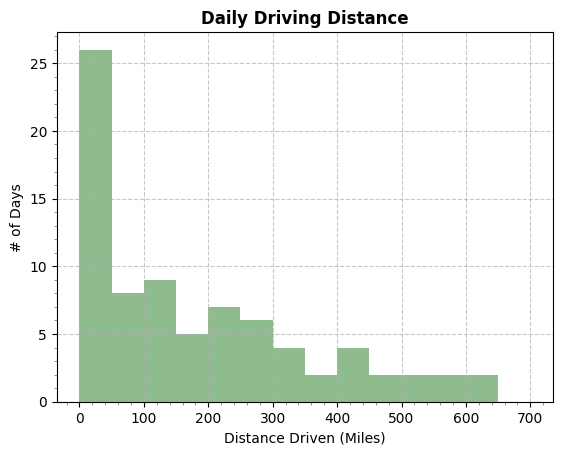

In [16]:
# Histogram for daily miles driven
custom_bins = list(range(0, 701, 50))
df['miles_driven'].hist(bins=custom_bins, color='darkseagreen')

plt.grid(True, linestyle='--', alpha=0.7)
plt.minorticks_on()
plt.tick_params(axis='both', which='minor', color='gray')
plt.title("Daily Driving Distance", fontweight='bold')
plt.xlabel("Distance Driven (Miles)")
plt.ylabel("# of Days");

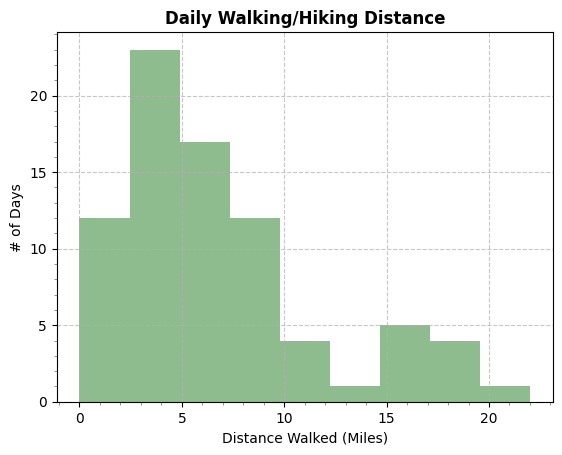

In [17]:
# Histogram for daily miles walked or hiked
df['miles_walked'].hist(bins=9, color='darkseagreen')

plt.grid(True, linestyle='--', alpha=0.7)
plt.minorticks_on()
plt.tick_params(axis='both', which='minor', color='gray')
plt.title("Daily Walking/Hiking Distance", fontweight='bold')
plt.xlabel("Distance Walked (Miles)")
plt.ylabel("# of Days");

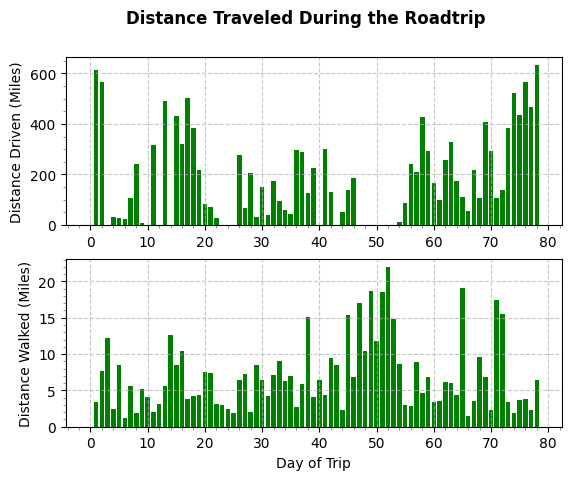

In [18]:
# Plot for distance driven and walked over time
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.bar(df.index, df['miles_driven'], color='green')
ax1.set_ylabel('Distance Driven (Miles)')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.minorticks_on()
ax1.tick_params(axis='both', which='minor', color='gray')

ax2.bar(df.index, df['miles_walked'], color='green')
ax2.set_xlabel('Day of Trip')
ax2.set_ylabel('Distance Walked (Miles)')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.minorticks_on()
ax2.tick_params(axis='both', which='minor', color='gray')

plt.suptitle("Distance Traveled During the Roadtrip", fontweight='bold');

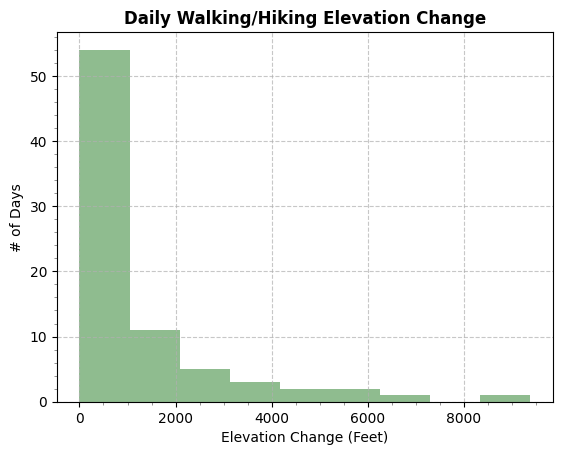

In [19]:
# Histogram for daily elevation change while walking
custom_bins=9
df['feet_elev_change'].hist(bins=custom_bins, color='darkseagreen')

plt.grid(True, linestyle='--', alpha=0.7)
plt.minorticks_on()
plt.tick_params(axis='both', which='minor', color='gray')
plt.title("Daily Walking/Hiking Elevation Change", fontweight='bold')
plt.xlabel("Elevation Change (Feet)")
plt.ylabel("# of Days");

Let's use another CSV that I manually created based on Google Maps data for keeping track of my mileage every time I crossed a state border to find the total mileage in every state:

In [20]:
### Read in state-specific mileage info
states_df = pd.read_csv('./roadtrip_data/states.csv')
states_df['state'] = states_df['state'].str.strip()

# Compute the distances traveled in each state in chronological order
states_df['next_entrance'] = states_df['entrance'].shift(-1)
states_df['distance'] = states_df['next_entrance'] - states_df['entrance']

# Compute total distance traveled in each state
distance_per_state = states_df.groupby('state')['distance'].sum()

# Adjust for the last leg of the trip
distance_per_state['Georgia'] += 14093 - states_df['entrance'].iloc[-1]

# Drop Alberta
distance_per_state = distance_per_state.drop('Alberta')

# Reorder by distance
distance_per_state.sort_values(ascending=False, inplace=True)

# Print top 10 states by distance
print(distance_per_state.head(10))

state
California      3614.0
Texas           2049.0
Washington      1708.0
Montana         1213.0
Arizona         1131.0
South Dakota     719.0
New Mexico       615.0
Oregon           565.0
Arkansas         351.0
Missouri         260.0
Name: distance, dtype: float64


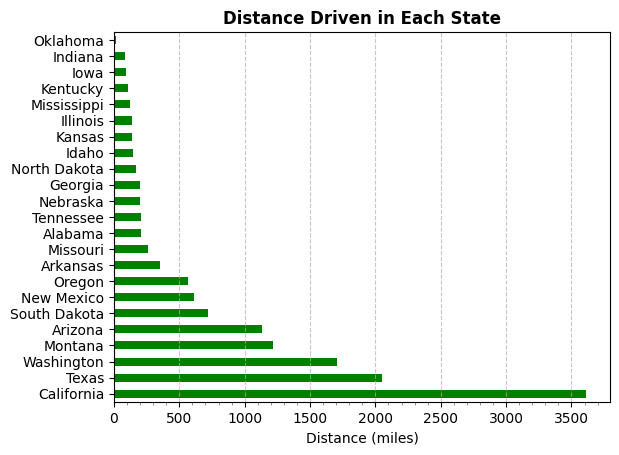

In [21]:
# Bar chart of distance per state
distance_per_state.plot.barh(color='green')
plt.grid(True, linestyle='--', alpha=0.7, axis='x')
plt.minorticks_on()
plt.tick_params(axis='y', which='minor', length=0, color='gray')
plt.tick_params(axis='x', which='minor', length=2, color='gray')
plt.title("Distance Driven in Each State", fontweight='bold')
plt.xlabel("Distance (miles)")
plt.ylabel('');

We can also represent this information using a heatmap where each state is colored in proportion to the amount of miles driven in it using the geopandas library:

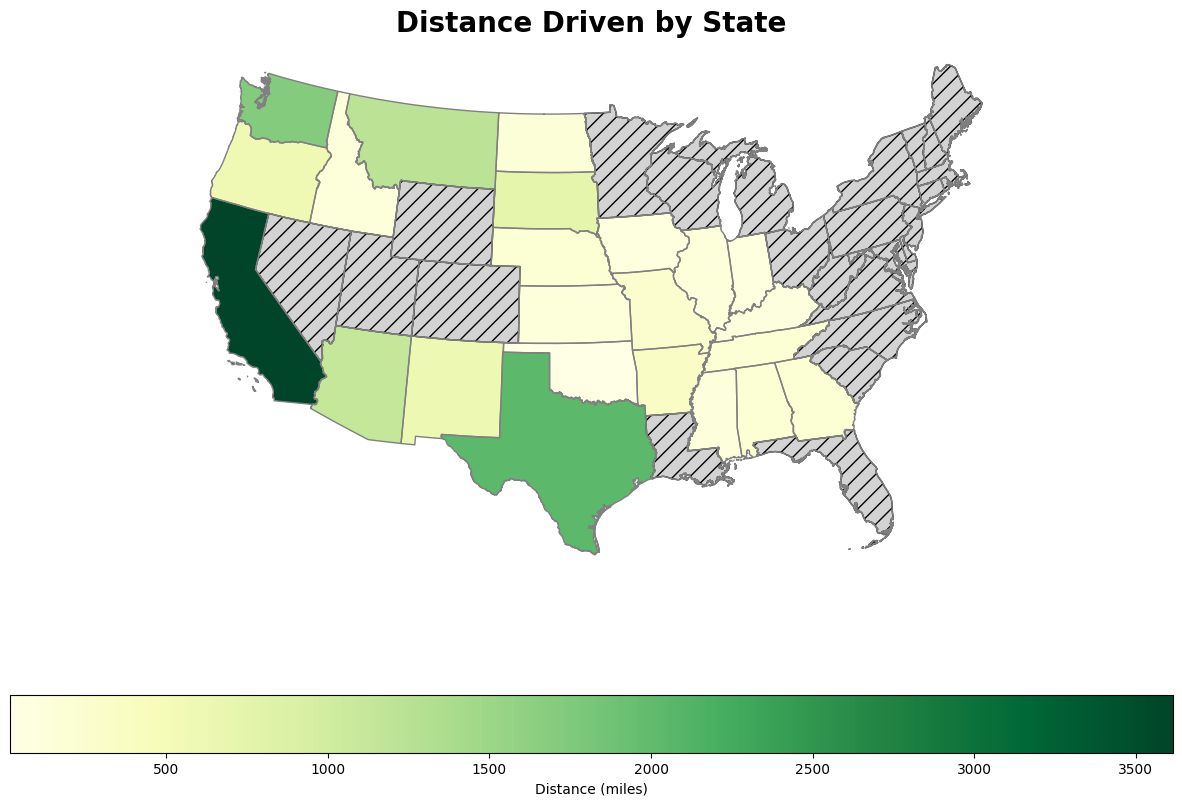

In [22]:
# Load a shapefile of the U.S.
gdf = gpd.read_file('./roadtrip_data/cb_2018_us_state_500k')

# Transform to equal area projection
gdf = gdf.to_crs(epsg=2163)

# Get names of all lower 48 states
states_df = pd.read_csv('./roadtrip_data/lower_48.csv')
states_df.set_index('State', inplace=True)

# Join and fill in missing states with NaN
distance_per_state = states_df.join(distance_per_state).fillna(0)

# Merge the map GeoDataFrame with the distances data
gdf = gdf.merge(distance_per_state, left_on='NAME', right_index=True)

# Plot the shapefile
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.boundary.plot(ax=ax, linewidth=1, color='grey')

# Plot the heatmap
gdf[gdf['distance'] > 0].plot(
    column='distance',
    ax=ax,
    legend=True,
    legend_kwds={
        'label': "Distance (miles)",
        'orientation': "horizontal"
    },
    cmap='YlGn'
)

# Plot the states with zero distances with hatching
gdf[gdf['distance'] == 0].plot(
    ax=ax,
    hatch='//',
    color='lightgrey',
    edgecolor='black'
)

plt.title('Distance Driven by State', fontweight='bold', fontsize='20')
plt.axis('off')
plt.show()

### Sleeping Location Statistics

We can start by plotting the latitude and longitude of my daily stopping points over time:

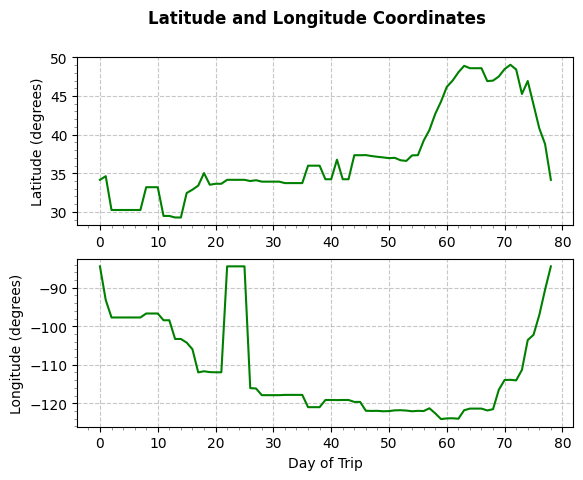

In [23]:
# Plot for sleeping longitude and latitude
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle("Latitude and Longitude Coordinates", fontweight='bold')

ax1.plot(
    df.index,
    df['sleeping_lat'],
    color='green',
    label='Sleeping Latitude'
)
ax1.set_ylabel('Latitude (degrees)')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.minorticks_on()
ax1.tick_params(axis='both', which='minor', color='gray')

ax2.plot(
    df.index,
    df['sleeping_long'],
    color='green',
    label='Sleeping Longitude'
)
ax2.set_xlabel('Day of Trip')
ax2.set_ylabel('Longitude (degrees)')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.minorticks_on()
ax2.tick_params(axis='both', which='minor', color='gray');

The spike in longitude on day 21 of the trip is due to the fact that I flew back to Atlanta from Phoenix one weekend. Interestingly, this discontinuity is not apparent in the latitude graph since the two cities have very similar latitudes.

Now let's take a look at how the places I slept each night are distributed geographically:

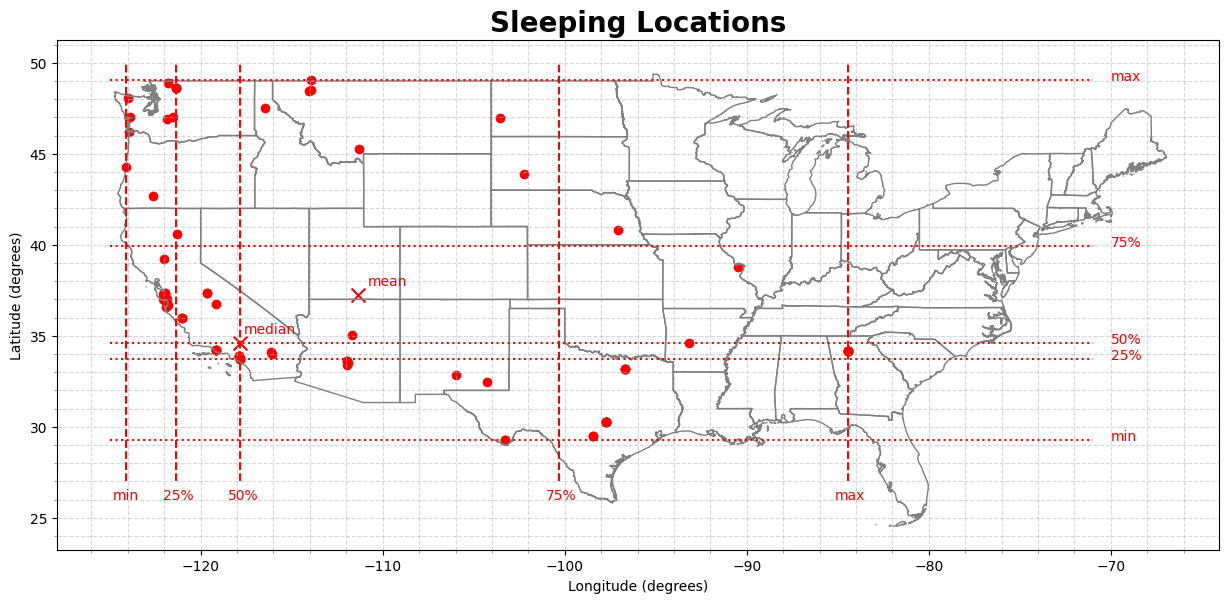

In [24]:
# Read in shapefile for the U.S.
gdf = gpd.read_file('./roadtrip_data/cb_2018_us_state_500k')
gdf = gdf[gdf.NAME.isin(states_df.index)]

# Make GeoDataFrame for the lat/long coordinates
coord_geometry = gpd.points_from_xy(df.sleeping_long, df.sleeping_lat)
coord_gdf = gpd.GeoDataFrame(df, geometry=coord_geometry)

# Plot the map and points
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.boundary.plot(ax=ax, linewidth=1, color='grey')
coord_gdf.plot(ax=ax, color='red')

# Plot the mean point
mean_x = df['sleeping_long'].mean()
mean_y = df['sleeping_lat'].mean()
ax.scatter(mean_x, mean_y, marker='x', s=100, color='red')
plt.annotate('mean', xy=(mean_x + 0.5, mean_y + 0.5), color='r')

# Plot the median point
median_x = df['sleeping_long'].median()
median_y = df['sleeping_lat'].median()
ax.scatter(median_x, median_y, marker='x', s=100, color='red')
plt.annotate('median', xy=(median_x + 0.2, median_y + 0.5), color='r')

# Plot quartile lines
lines = [
    ['sleeping_lat', 'min', ':'],
    ['sleeping_lat', '25%', ':'],
    ['sleeping_lat', '50%', ':'],
    ['sleeping_lat', '75%', ':'],
    ['sleeping_lat', 'max', ':'],
    ['sleeping_long', 'min', '--'],
    ['sleeping_long', '25%', '--'],
    ['sleeping_long', '50%', '--'],
    ['sleeping_long', '75%', '--'],
    ['sleeping_long', 'max', '--']
]

def plot_line(input):
    coord, stat, line = input
    desc = df[coord].describe()[stat]
    
    if coord == 'sleeping_lat':
        x = list(range(-125, -70))
        y = np.zeros(len(x)) + desc
        plt.annotate(stat, xy=(x[-1] + 1, y[-1]), color='r')
    elif coord == 'sleeping_long':
        y = list(range(27, 51))
        x = np.zeros(len(y)) + desc
        plt.annotate(stat, xy=(x[-1] - 0.7, y[0] - 1), color='r')
    
    ax.plot(x,y, linestyle=line, color='red')

for line in lines:
    plot_line(line)

plt.title('Sleeping Locations', fontweight='bold', fontsize='20')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
ax.minorticks_on()
ax.tick_params(axis='both', which='minor', color='gray')
ax.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

Intuitively, the quartiles make sense here since I spent nearly a third of my roadtrip in California.

What was the distribution of the different kinds of sleeping arrangements that I had over the trip?

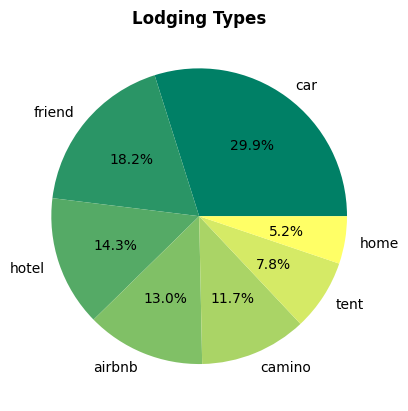

In [25]:
colors = plt.get_cmap("Blues")(
    range(len(df['lodging_type'].value_counts()))
)
ax = df['lodging_type'][1:-1].value_counts().plot.pie(
    cmap='summer',
    autopct='%1.1f%%'
)
plt.title("Lodging Types", fontweight='bold')
ax.set_ylabel('');

Nearly 56% of my nights were spent at places that were free (car, tent, friend). The "camino" category refers to a week-long walking pilgrimage in California during which I slept on the floor of churches along the way.

Let's take a look at how the amount of sleep I got each night:

In [26]:
# Sleep duration
print('\nMean sleep duration: {:.2f} hours'.format(
    df['sleep_duration'][1:].mean()
))


Mean sleep duration: 7.13 hours


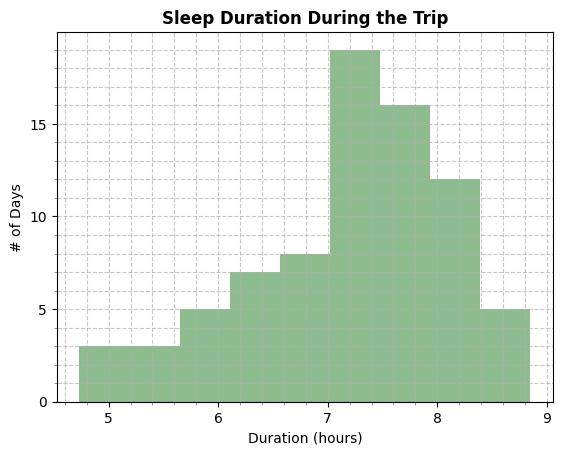

In [27]:
# Histogram for hours of sleep
df['sleep_duration'][1:].hist(bins=9, color='darkseagreen')

plt.yticks(range(0, 20, 5))
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.minorticks_on()
plt.tick_params(axis='both', which='minor', color='gray')
plt.title("Sleep Duration During the Trip", fontweight='bold')
plt.xlabel("Duration (hours)")
plt.ylabel("# of Days");

### Hygiene Statistics

In [28]:
showered = df['showered'][df['showered']].sum()
pc_showered = showered / len(df) * 100
print('I showered on {:.1f}% of the days.'.format(pc_showered))

I showered on 77.2% of the days.


I promise I didn't smell...that much.

### Heart Rate Statistics

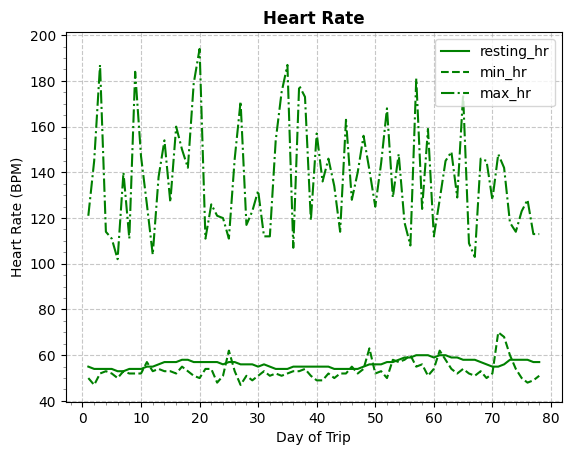

In [29]:
# Plot for resting heart rate
df['resting_hr'][1:].plot(color='green', linestyle='-')
df['min_hr'][1:].plot(color='green', linestyle='--')
df['max_hr'][1:].plot(color='green', linestyle='-.')
plt.grid(True, which='major', linestyle='--', alpha=0.7)
plt.minorticks_on()
plt.tick_params(axis='both', which='minor', color='grey')
plt.legend()
plt.title('Heart Rate', fontweight='bold')
plt.xlabel('Day of Trip')
plt.ylabel('Heart Rate (BPM)');

One thing that really stands out in this graph is that there are a few days where the minimum heart rate is much higher than on other days. These points could be outliers, or there could be more to the story. I wonder what I did on these days?

In [30]:
# Seperate min HR data
min_hr_df = df[['date', 'min_hr']]

# Sort values
min_hr_df = min_hr_df.sort_values(by='min_hr', ascending=False)

# Display outliers
min_hr_df[min_hr_df['min_hr'] > 60]

,date,min_hr
day,,
71,18-Jul,70
72,19-Jul,68
49,26-Jun,63
61,8-Jul,62
25,2-Jun,62


Can these abnormally high values be explained by my activities those days?

- July 18-19: I was hiking nearly all day in Glacier and Waterton Lakes National Parks, where the elevation ranged from 5000 feet to over 7000 feet. My heart definitely would have had to work harder at these higher altitudes.
- June 26: I was walking/hiking for the majority of this day, but at altitudes closer to 2000 feet, so altitude doesn't explain this one.
- July 8: My body was battling a pretty severe cold, and I felt the most sick this day.
- June 2: I was in a particularly stressful social environment this day.

Can I similarly explain the abnormally high max heart rate values? I expect that most if not all of these outliers will be on days that I went for a run.

In [31]:
# Seperate max HR data
max_hr_df = df[['date', 'max_hr']]

# Sort values
max_hr_df = max_hr_df.sort_values(by='max_hr', ascending=False)

# Display outliers
max_hr_df[max_hr_df['max_hr'] > 180]

,date,max_hr
day,,
20,28-May,194
35,12-Jun,187
3,11-May,187
9,17-May,184
57,4-Jul,181


As expected, the top four max heart rates occurred on days I went for a run, the highest heart rate occuring when I ran down Piestewa Peak in Phoenix on a really hot morning. The July 4 max, however, occured while I was hiking up Cinder Cone in Lassen Volcanic National Park, one of the steepest hikes I've ever done.

### Caloric Expenditure

In [32]:
df['total_calories'] = df['active_calories'] + df['resting_calories']
df['total_calories'][1:].describe()

count      78.000000
mean     2370.641026
std       465.084519
min      1826.000000
25%      1999.000000
50%      2267.000000
75%      2530.500000
max      3906.000000
Name: total_calories, dtype: float64

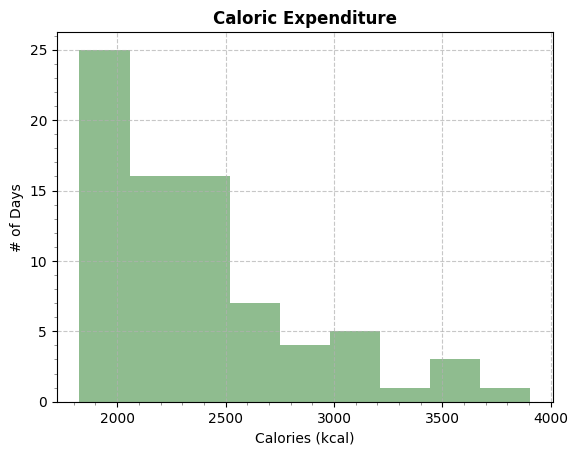

In [33]:
# Histogram of caloric expenditure
df['total_calories'][1:].hist(bins=9, color='darkseagreen')

plt.grid(True, which='major', linestyle='--', alpha=0.7)
plt.minorticks_on()
plt.tick_params(axis='both', which='minor', color='grey')
plt.title('Caloric Expenditure', fontweight='bold')
plt.xlabel('Calories (kcal)')
plt.ylabel('# of Days');

Nothing too surprising here. The days when I burned the most calories were the days I walked/hiked the furthest.

### Finanial Expenses

*To Be Completed*

<a id='conclusions'></a>
## Conclusions

The outcome of this initial EDA has been various visualizations of roadtrip-related data. Next steps for this project will involve additions to the dataset, further analysis of the relationships between variables, and inquiry into how I can increase my enjoyment while limiting my expenses on future trips.

### Next Steps
1. Fix time zone localization and plot wakeup and bed times over the trip.
2. EDA of travel expenses
3. Create more heatmaps, including time spent in each state and cost in each state.
3. Incorporate historical weather data into the dataset.
4. Estimate fuel costs in each state based on historical gas price data.
5. Compare a self-reported measure of enjoyment each day vs. all the other variables

### Reference
1. https://pandas.pydata.org/docs/user_guide/index.html
2. https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
3. https://stackoverflow.com/questions/15742045/getting-time-zone-from-lat-long-coordinates
4. https://medium.com/@alex_44314/use-python-geopandas-to-make-a-us-map-with-alaska-and-hawaii-39a9f5c222c6


***